<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Really-simple-DQN:-DQN-&amp;-vectorized-Double-DQN" data-toc-modified-id="Really-simple-DQN:-DQN-&amp;-vectorized-Double-DQN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Really simple DQN: DQN &amp; vectorized Double DQN</a></span><ul class="toc-item"><li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prerequisites</a></span></li><li><span><a href="#Goals" data-toc-modified-id="Goals-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Goals</a></span></li></ul></li><li><span><a href="#Reward-clipping-&amp;-Huber-loss" data-toc-modified-id="Reward-clipping-&amp;-Huber-loss-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reward clipping &amp; Huber loss</a></span></li><li><span><a href="#First-iteration:-replay-buffer-without-target-network" data-toc-modified-id="First-iteration:-replay-buffer-without-target-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>First iteration: replay buffer without target network</a></span><ul class="toc-item"><li><span><a href="#One-weird-trick..." data-toc-modified-id="One-weird-trick...-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>One weird trick...</a></span></li></ul></li><li><span><a href="#Training-the-SimpleDQN-agent" data-toc-modified-id="Training-the-SimpleDQN-agent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training the SimpleDQN agent</a></span></li><li><span><a href="#A-Double-Dose-of-DQN" data-toc-modified-id="A-Double-Dose-of-DQN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A Double Dose of DQN</a></span><ul class="toc-item"><li><span><a href="#Double-DQN-implementation" data-toc-modified-id="Double-DQN-implementation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Double DQN implementation</a></span></li></ul></li><li><span><a href="#Effects-of-reward-clipping-on-learning-&amp;-performance-in-LunarLander" data-toc-modified-id="Effects-of-reward-clipping-on-learning-&amp;-performance-in-LunarLander-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Effects of reward clipping on learning &amp; performance in LunarLander</a></span></li><li><span><a href="#Upcoming" data-toc-modified-id="Upcoming-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Upcoming</a></span></li></ul></div>

# Really simple DQN: DQN & vectorized Double DQN

>  ...Read about DQN... policy gradients, particular A3C... Just go to /r/machinelearning on Reddit and look at some recent papers in the deep neural net literature. Look at them try to re-implement [them], see if you can get results as good as the results that others get. It’s really pretty self-contained and you don’t need that much help... If you’re having trouble getting started implementing them... you can find it an existing implementation then start with that and try to fiddle with it to see if you can make it better...

> [Dario Amodi, on 80,000 hours podcast](https://80000hours.org/podcast/episodes/the-world-needs-ai-researchers-heres-how-to-become-one/)

*Okay. Seems like fun.* 

During May and June 2018 I've been reading reinforcement learning papers, watching lectures and more or less trying to follow the path Dario Amodi lays out, driven by similar motivations: I'm an active, enthusiastic Effective Altruist, and I buy the AI Safety arguments. Even if you don't see General AI as a threat, there are still clearly safety and alignment issues to think about with current and future ML/AI systems. 

In this document I present my implementations of DQN and DoubleDQN and discuss some relevant issues and questions from my own experience and from the literature. I think my DQN implementation in particular might be more straightforward and readable than other implementations I've seen. OpenAI's baselines, for example, are extremely general, and one might be tempted to call them over-engineered.

I am a neophyte in this field. This is a document of my exploration and learning process. I am not an authoritative source.

I have be using OpenAI gyms as the training environments, and have trialled both Keras and Pytorch for different parts of this work. I've been almost entirely working alone on this, but at a few points have looked at other people's implementations and explanations. In particular, Jaomiru's [Let’s make a DQN](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/) series was helpful getting started, and I've had a couple of good, useful chats with my friend William Saunders. But I've also re-learned the lesson I constantly learn and relearn: sometimes you need to seek out additional material to understand things. But sometimes you're just scared to sit with a difficult thing and wrestle with it. Sometimes it's difficult to know when you're unproductively banging your head against a wall, vs when you're productively banging your head against a wall. 

## Prerequisites
- Reinforcement learning basics, some degree of familiarity with DeepMind's results with DQN and extensions.

## Goals

My goals for this series are to write extremely simple and readable implementations of a number of important Reinforcement Learning Algorithms (upcoming are implementations of the Prioritized Experience Replay and Distributional extensions to DQN), and to document my development and learning in an incremental literate-programming style. 

All right then. Let's begin.

In [2]:
from collections import deque
from itertools import product
import json
import math
import os
import random

import attr  # Better/simplied Python classes. http://attrs.readthedocs.io
import gym
import keras
from keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
from smooth import smooth  # timeseries smoothing function
import tensorflow as tf


np.random.seed(0)  # pin rng seed
cartpole = gym.make('CartPole-v1')
lunarlander = gym.make('LunarLander-v2')
plt.style.use('seaborn-white')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Almost all my explorations have been in the simpler [OpenAI Gym](https://gym.openai.com/) environments to increase speed of development and avoid unnecessary complexity. The original DeepMind papers on learning to play Atari used convo nets and raw pixels, but the preprocessing for the pixels itself adds extra complexity and we can implement DQN using a much simpler ReLU agent.

---
> Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as Q) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to Q may significantly change the policy and therefore change the data distribution, and the correlations between the action-values (Q) and the target values $r + \gamma\max_a Q(s', a')$. We address these instabilities with a novel variant of Q-learning, which uses two key ideas. 

> **First, we used a biologically inspired mechanism termed experience replay that randomizes over the data, thereby removing correlations in the observation sequence and smoothing over changes in the data distribution...**

> **Second, we used an iterative update that adjusts the action-values (Q) towards target values that are only periodically updated, thereby reducing correlations with the target.**

> [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

In [3]:
@attr.s
class Memory(deque):
    """ Experience Replay Memory class. """
    size = attr.ib()
    minibatch_size = attr.ib()

    def append(self, thing):
        if len(self) > self.size - 1:
            self.popleft()
        return super().append(thing)

    def sample(self):
        batch_size = min(len(self), self.minibatch_size)
        return random.sample(self, batch_size)

    
def huber_loss(y_true, y_pred, delta=2):
    """ Used for clipping error gradients to the interval [-1, 1]. """
    delta = 2.0
    err = y_true - y_pred
    L2 = 0.5 * K.square(err)
    L1 = delta * (K.abs(err) - 0.5 * delta)
    loss = tf.where(K.abs(err) < delta, L2, L1)
    return K.mean(loss)
    
        
def make_network(state_shape, action_shape, num_hidden_units, loss='mse'):
    net = keras.Sequential()
    net.add(keras.layers.Dense(num_hidden_units, activation='relu', input_shape=state_shape))
    net.add(keras.layers.Dense(action_shape, activation='linear'))    
    net.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse')    
    return net


def spines_off(axes):
    """ Turns off the frame around matplotlib figures. """
    for ax, side in product(axes, ('top','right', 'bottom', 'left')):
        ax.spines[side].set_visible(False)

[Attrs](http://attrs.readthedocs.io/), btw, is lovely package that simplifies Python classes. As Glyph says, it's the [sexy, exciting Python of the future](https://glyph.twistedmatrix.com/2016/08/attrs.html#fn:2).

# Reward clipping & Huber loss

>While we evaluated our agents on unmodified games, we made one change to the reward structure of the games during training only. As the scale of scores varies greatly from game to game, we clipped all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged...

>...We also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s',a') - Q(s, a)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of $x$ and a derivative of 1 for all positive values of $x$, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

> [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

These two paragraphs are possibly the most confusing parts of the DQN paper. 

The implementation of reward clipping is straightforward -- we can just do: 

```
state_, reward, episode_done, _ = self.env.step(action)
reward = np.clip(reward, self.reward_clip_floor, self.reward_clip_ceiling)                                
```

However reward clipping seems to have complex effects on training and the loss function being used. Which brings us to error term clipping. It's quite easy to mis-read the paper here as suggesting that $r + \gamma \max_{a'} Q(s',a') - Q(s, a)$ [should be clipped](https://github.com/devsisters/DQN-tensorflow/issues/16#issuecomment-268190925), however, the actual intention is to use [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which clips *the gradient*. Why didn't they just say "we used Huber loss"? `¯\_(ツ)_/¯` 

> ...when I was experimenting with getting rid of the reward clipping in DQN I also got rid of the huber loss in the experiments. Our focus was much more on the clipping of the rewards though. If you're interested, our NIPS paper has more details:  [Learning values across many orders of magnitude](https://arxiv.org/abs/1602.07714) The short: hugely beneficial on some games, not so good on others.

> More research on the effect of different cost functions in deep RL would definitely be good.
>
> - Hado can Hesselt

And in [A Distributional Perspective on Reinforcement Learning](https://arxiv.org/pdf/1707.06887.pdf), a later (fascinating!) DeepMind paper, the authors write:

> In this work we used distributions with support bounded in $[V_{MIN},V_{MAX}]$. Treating this support as a hyperparameter allows us to change the optimization problem by treating all extremal returns (e.g. greater than $V_{MAX}$) as equivalent. Surprisingly, *a similar value clipping in DQN significantly degrades performance in most games.*

I'll be writing significantly more about Distributional DQN shortly, but my own limited experiments with reward clipping suggest that it can be pretty harmful to training -- as we'll see below, [my LunarLander agent, trained with reward clipping, significantly underperformes compared to the version trained without clipping](#Effects-of-reward-clipping-on-learning-&-performance-in-LunarLander), when tested in an environment that doesn't clip rewards. This seems intuitive to me, as the LunarLander environment has a carefully designed shaped-reward function. We should be surprised if clipping *doesn't* interfere with training in such a situation.

If you're curious to read more on this issue:
- https://github.com/devsisters/DQN-tensorflow/issues/16#issuecomment-306162797 [logged by Karpathy!]
- https://www.reddit.com/r/MachineLearning/comments/6dmzdy/d_on_using_huber_loss_in_deep_qlearning/
- https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
- https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
- https://github.com/devsisters/DQN-tensorflow/issues/16#issuecomment-268190925

In [29]:
@attr.s
class AgentBaseClass:
    """ Takes care of record training data and other house-keeping tasks. """
    env = attr.ib()
    discount_rate = attr.ib(default=0.99)
    epsilon_max = attr.ib(default=1.0)
    epsilon_min = attr.ib(default=0.01)
    annealing_const = attr.ib(default=.001)  # aka Lambda
    minibatch_size = attr.ib(default=64)
    memory_size = attr.ib(default=int(1e6))
    num_episodes = attr.ib(default=1000)  # num of episodes in a training epoch
    num_hidden_units = attr.ib(default=64)
    render_every = attr.ib(default=20)  # set to zero to turn off rendering
    update_target_every = attr.ib(default=200)
    reward_clip_ceiling = attr.ib(None)
    reward_clip_floor = attr.ib(None)

    def __attrs_post_init__(self):
        self.steps = 0
        self.reset_memory()
        self.reset_data_recorders()
        self.state_shape = self.env.observation_space.shape
        self.action_shape = self.env.action_space.n
        if self.reward_clip_ceiling and self.reward_clip_floor:
            self.online_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units, loss=huber_loss)
        else:
            self.online_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units, loss='mse')        
        
    def reset_memory(self):
        self.memory = Memory(self.memory_size, self.minibatch_size)

    def reset_data_recorders(self):
        self.episode_rewards = []
        self.episode_losses = []
        self.td_errors = []
        self.online_net_q_values = []
        self.target_net_q_values = []
        self.w1_gradient = []
        self.w2_gradient = []

    def q_value_one(self, net, state):
        return net.predict(state.reshape((1, self.state_shape[0]))).flatten()

    def training_progress_report(self, episode):
        last_ep = self.episode_rewards[-1]
        ten_ep_mean = sum(self.episode_rewards[-10:])/len(self.episode_rewards[-10:])
        hundred_ep_mean = sum(self.episode_rewards[-100:])/len(self.episode_rewards[-100:])
        return f'Ep: {episode} // steps: {self.steps} // last ep reward: {last_ep:.2f} // {min(10, len(self.episode_rewards[-10:]))}-ep mean: {ten_ep_mean:.2f} // {min(100, len(self.episode_rewards[-100:]))}-ep mean: {hundred_ep_mean:.2f}'

    def render(self, episode):
        if self.render_every and episode % self.render_every == 0:
            self.env.render()

    def train(self):
        raise NotImplementedError
        
    def test(self, num_episodes=500):
        """ Evaluate a trained agent. """
        episode_done = False
        self.reset_data_recorders()
        self.reward_clip_ceiling = None
        self.reward_clip_floor = None    
        self.steps = 0
        for episode in range(num_episodes):
            episode_td_errors = 0
            episode_reward = 0       
            episode_done = False
            state = self.env.reset()  
            self.target_net_q_values.append(float(self.q_value_one(self.target_net, state).max() ))
            while not episode_done:            
                action = self.q_value_one(self.online_net, state).argmax()                    
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                episode_reward += reward
                episode_td_errors += self.replay(target_net=self.online_net, online_net=self.online_net)
                state = state_
                if episode_done:
                    self.episode_rewards.append(float(episode_reward))                    
                    self.td_errors.append(float(episode_td_errors))
                    print('Test:' + self.training_progress_report(episode), end='\r', flush=True)                                        
        self.env.close()       

    def plot_training_results(self, fig_title):
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        self.fig, self.axes = fig, axes
        fig.suptitle(fig_title, fontsize=16, y=1.02)
        spines_off(axes)
        ax1, ax2, ax3 = axes

        ax1.set_title('Smoothed episode rewards')
        ax1.plot(smooth(np.array(self.episode_rewards)))

        ax2.set_title('Estimated Q values')
        if self.target_net_q_values:        
            ax2.plot(self.target_net_q_values, alpha=0.7)        
            vlines = [self.update_target_every * i for i in range(1, self.num_episodes//self.update_target_every + 1)]
            ax2.vlines(vlines, 0, max(self.target_net_q_values), linestyles='dotted', alpha=0.5, linewidth=0.5)
        else:
            ax2.plot(self.online_net_q_values)        
        ax2.hlines(100, 0, len(self.online_net_q_values), linestyles='dotted', linewidth=1)            

        ax3.set_title('Smoothed temporal difference errors')        
        ax3.plot(smooth(np.array(self.td_errors), window_len=100));

# First iteration: replay buffer without target network
This is the full DQN algorithm we're working towards implementing:

![The DQN algorithm](assets/DQN algo.png)

But for our iteration we're just going to implement the replay buffer and skip the target network. The target network is denoted with $\hat{Q}$ in the paper -- for this first iteration, everywhere $\hat{Q}$ appears, we'll just use $Q$, the online network.

We're going to ignore the parts that deal with $\phi$ and preprocessing -- those are details that are specific to working with images as input. Personally, I found those parts of the algorithm specification confusing and distracting when I was initially reading the paper. 

Our transitions will be $(state_t, action_t, reward_t, state_{t+1}, done)$, with $done$ indicating that a transition is terminal. $\hat{Q}$ and $Q$ represent the target network and online network, respectively. We are also not implementing the target network in this initial version -- it will be simple to add in shortly, though.

Our agents will implement two methods, `train` and `replay`. `Train` is the main loop, implementing everything up till the line "Store transition in replay memory D". `Replay` takes care of the sampling the minibatches, computing the update targets and performing the the optimization steps. 

Our specific `replay` implementation expects references to the online_net and the target_net. For the first implementation, we will call `self.replay(target_net=self.online_net, online_net=self.online_net)`, to show the impact of training without the target network.

In [19]:
@attr.s
class DqnWithoutTargetNet(AgentBaseClass):
    """ Demonstrates the importance of the target net for stable training. """
    def replay(self, target_net, online_net):
        """ Calculate the target values for y_j on a minibatch and do a gradient descent step. """
        # Q_network gives us Vals for all actions in one forward pass:
        batch = self.memory.sample()  # (minibatch_size x state_shape)
        states = np.array([transition[0] for transition in batch])
        y = target_net.predict(states)  # (minibatch_size, action_shape). These are target scores for state
        terminal_state = np.zeros(self.state_shape)  # We need special handling if the transition is the last in a rollout.
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in batch])
        y_ = target_net.predict(states_)  # (minibatch_size, action_shape). These are target scores for state'

        for idx, transition in enumerate(batch):
            state, action, reward, state_, terminal = transition
            if state_ is None:
                y[idx, action] = reward
            else:
                y[idx, action] = reward + self.discount_rate * np.amax(y_[idx])
        # Q is a func from (state, action) to expected values for each action.
        td_error = np.linalg.norm(y - y_)/self.minibatch_size
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)
        return td_error

    def train(self):
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            episode_td_errors = 0
            state = self.env.reset()
            self.online_net_q_values.append(self.q_value_one(self.online_net, state).max())
            while not episode_done:
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1
                # Epsilon greedy action:
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.q_value_one(self.online_net, state).argmax()
                    
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                if self.reward_clip_floor and self.reward_clip_ceiling: 
                    reward = np.clip(reward, self.reward_clip_floor, self.reward_clip_ceiling)                                
                episode_reward += reward
                if episode_done:
                    state_ = None                
                self.memory.append((state, action, reward, state_, episode_done))
                episode_td_errors += self.replay(target_net=self.online_net, online_net=self.online_net)
                state = state_
                if episode_done:
                    self.episode_rewards.append(float(episode_reward))
                    self.td_errors.append(float(episode_td_errors))
                    print(self.training_progress_report(episode), end='\r', flush=True)
        self.env.close()

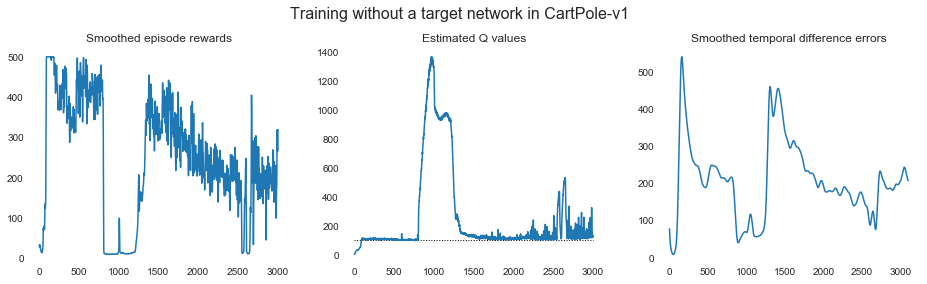

In [31]:
first_dqn = DqnWithoutTargetNet(env=cartpole, num_episodes=3000)
first_dqn.train()
first_dqn.plot_training_results(fig_title='Training without a target network in CartPole-v1')

## One weird trick...

Note how unstable the episode rewards are, and the massive over-estimates for the Q values. How massive? Our environment is capped at 500 steps, and the discounted reward is estimated with $Q = r_1 + \gamma r_2 +\gamma^2 r_3 + ... + \gamma^{499} r_{500}$. Using $\gamma=0.99$, the Q estimate for CartPole should be ~100.  The dotted line at the base of the 'Estimated Q values' graph is drawn at a value of 100, and drops in the Episode Rewards clearly correspond to spikes in the Q values. One of the causes is "the correlations between the action-values (Q) and the target values" which are used to estimate what the values of $state'$ will be. Adding in the target network will address this problem:

In [24]:
@attr.s
class SimpleDqn(DqnWithoutTargetNet):
    def __attrs_post_init__(self):
        super().__attrs_post_init__()
        # Remember, the target net isn't subject to optimization, it gets its values periodically from the online
        # net. So we don't worry about the loss func here.  
        self.target_net = make_network(self.state_shape, self.action_shape, self.num_hidden_units)
                        
    def train(self):
        for episode in range(self.num_episodes):
            episode_done = False
            episode_reward = 0
            episode_td_errors = 0
            state = self.env.reset()
            self.online_net_q_values.append(float(self.q_value_one(self.online_net, state).max()))
            self.target_net_q_values.append(float(self.q_value_one(self.target_net, state).max()))
            while not episode_done:
                epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * math.exp(-self.annealing_const * self.steps)
                self.steps += 1
                if random.random() < epsilon:
                    action = random.randint(0, self.action_shape-1)
                else:
                    action = self.q_value_one(self.online_net, state).argmax()
                self.render(episode)
                state_, reward, episode_done, _ = self.env.step(action)
                if self.reward_clip_floor and self.reward_clip_ceiling: 
                    reward = np.clip(reward, self.reward_clip_floor, self.reward_clip_ceiling)
                episode_reward += reward
                if episode_done:
                    state_ = None                
                self.memory.append((state, action, reward, state_, episode_done))
                episode_td_errors += self.replay(target_net=self.target_net, online_net=self.online_net)
                state = state_
                if self.steps % self.update_target_every == 0:
                    self.target_net.set_weights(self.online_net.get_weights())
                if episode_done:
                    self.episode_rewards.append(float(episode_reward))
                    self.td_errors.append(float(episode_td_errors))
                    print(self.training_progress_report(episode), end='\r', flush=True)
        self.env.close()

Note that the only significant difference between `SimpleDqn` and its parent `DqnWithoutTargetNet` is line 28: 

```python
self.replay(target_net=self.target_net, online_net=self.online_net)
```
This change means we pass the target net to `replay`, thus using the target net to predict $y_j$ values for the optimization step where we aim to minimize $(y_j - Q(s, a))^2$. Below we'll see the impact of this one change.

---

# Training the SimpleDQN agent

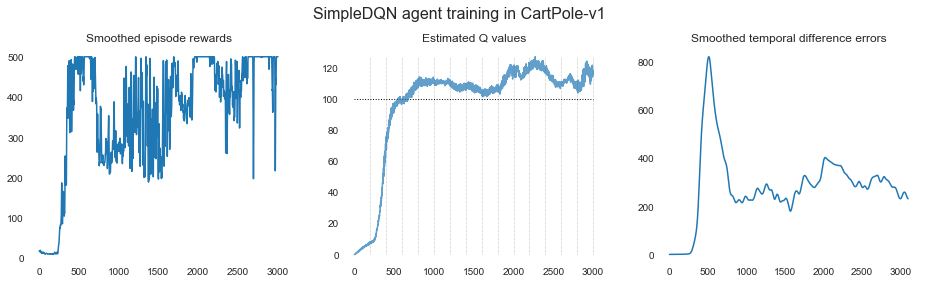

In [25]:
simple_dqn = SimpleDqn(env=cartpole, num_episodes=3000)
simple_dqn.train()
simple_dqn.plot_training_results(fig_title='SimpleDQN agent training in CartPole-v1')


In `DqnWithoutTargetNet` we only have the `online_net`, so the `online_net` is used both for the state-value estimates and is the objective function that is being optimized. In `SimpleDqn` as per the DeepMind paper, we split those two functions and the result is a massive improvement in the agent. In fact, the `DqnWithoutTargetNet` often performs about as well as a random agent, whereas `SimpleDqn` quickly learns to saturates the task. However, `SimpleDqn` only really begins to improve after the first update of the target network. Prior to that, it also performs about as well as a random agent. After the first update, there is an almost immediate take-off in learning. 

The authors expand on the reason this improves learning by saying:

> Q-learning, where an update that increases $Q(s_t,a_t)$ often also increases $Q(s_{t+1}, a)$ for all $a$ and hence also increases the target $y_j$, possibly leading to oscillations or divergence of the policy. Generating the targets using an older set of parameters adds a delay between the time an update to $Q$ is made and the time the update affects the targets $y_j$, making divergence or oscillations much more unlikely.

Note that the Q values overall are stable, but also that they tend to be greater than 100. That is, DQN is over-optimistic. 

Vertical lines in the Q-values plot above indicate when the target network is updated with weights from the online network.

---


# A Double Dose of DQN

There have been a number of extensions and improvements made to the DQN framework. [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf) (2015) is an interesting paper because it's particularly straightforward to implement, and fundamentally very simple to understand -- although the 2015 DeepMind paper almost seems to go out of its way to obscure the issue. 

In DQN the target values are defined as:

$$ y_j = r_j + \gamma \max_{a'} \hat{Q}(s_{j+1}, a') $$ 

Where $\hat{Q}$ stands for the target network, as opposed to $Q$, the online network.

With Double Q-learning we use:

$$ y_j = r_j + \gamma \max_{a'} \hat{Q}(s_{j+1}, \underset{a}{\operatorname{argmax}} Q(s_{j+1}, a))$$ 

To understand why we would want to do this, we first we need to understand the problem DDQN is solving:

- DQN has an optimism bias, which can sometimes be severe, and which can negatively affect learning -- eg, imagine if you're overly optimistic about the 1st choice you make. Exploration stops.
- Double DQN reduces the lower-bound on the absolute error of the Q-value estimates. 

The explanation for *why* DDQN helps with the optimism bias is actually quite simple, but the 2015 paper doesn't give a clear presentation of this. To get a simple, intuitive understanding of what's going on, we can turn to Hado van Hasselt's PhD dissertation:

> If actions that are selected often suffer from overestimations, these actions will only get selected more and more. On the other hand, if actions that are selected suffer from underestimations, this will give an incentive to the algorithm to try other actions.

![van%20Hesselt.png](assets/van%20Hesselt.png)

<figcaption>From Hesselt's 2010 dissertation, *Insighting in Reinforcement Learning*. </caption>

DoubleDQN helps address this problem by separating the selection of *location* to sample from the *evaluation* of samples. Using the figure above, if we want to estimate the max value of the function, we need two different noisy estimators. First we chose $\hat{x} = argmax_x(estimator_1(x))$ then we can estimate the max value, $\hat{y}$ as $max(estimator_2(\hat{x}))$ and get an unbiased estimate of the max of the function.

## Double DQN implementation

(Note that we're now also switching to a vectorized implementation of the replay logic.)

In [26]:
@attr.s
class DoubleDqn(SimpleDqn):
    def replay(self, target_net, online_net):
        # unpack the batch data and convert to nunpy arrays:
        batch = self.memory.sample()  # (minibatch_size x state_shape)
        states = np.array([transition[0] for transition in batch])
        transition_actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])  # (batch x 1)
        terminal_mask = np.array([True if transition[3] is None else False for transition in batch])  # (batch x 1)
        terminal_state = np.zeros(self.state_shape)
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in batch])  # (batch x state-size)

        y = target_net.predict(states)  # (batch x num-actions)
        online_predicted_actions = online_net.predict(states).argmax(axis=1)  # batch x num-action
        y_ = target_net.predict(states_)  # (batch x num-actions)

        # set y = r for terminal states:
        terminal_state_actions = transition_actions[terminal_mask]
        y[terminal_mask, terminal_state_actions] = rewards[terminal_mask]

        # DDQN update:
        # set y = r + gamma * Q_hat(s', argmax Q(s', a'))
        non_terminal_mask = ~terminal_mask
        best_actions = online_predicted_actions[non_terminal_mask]
        non_terminal_actions = transition_actions[non_terminal_mask]
        y[non_terminal_mask, non_terminal_actions] = rewards[non_terminal_mask] + self.discount_rate * y_[non_terminal_mask, best_actions]
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)
        
        # Return TD error for this minibatch. Useful metric to track.
        return np.linalg.norm(y_ - y)/self.minibatch_size

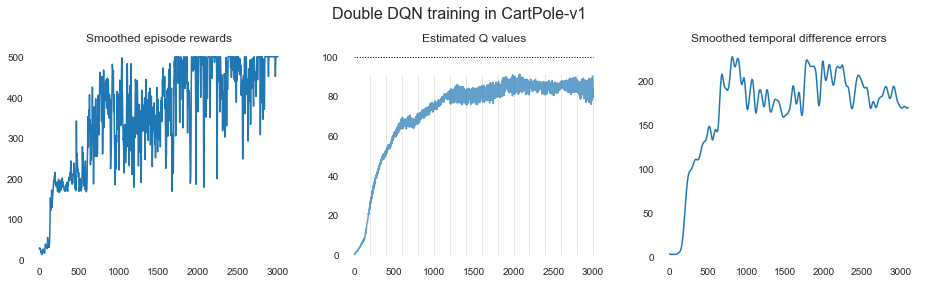

In [28]:
double_dqn = DoubleDqn(env=cartpole, num_episodes=3000)
double_dqn.train()
double_dqn.plot_training_results(fig_title='Double DQN training in CartPole-v1')

Here Double DQN performes significantly better than Vanilla DQN. Also Note how Double DQN's Q value estimates are systematically *pessimistic* -- we've corrected for the optimism bias that regular DQN has. It seems like double DQN's more conservative value estimates may mean that it takes longer to converge to the true expected discounted value, but when it does, it should be more stable. 

Vertical lines in the Q values plot indicate when the target network is updated with weights from the online network.

# Effects of reward clipping on learning & performance in LunarLander

Rewards in the CartPole environment are just +1 for every time step. In order to explore the affect of reward and gradient clipping on training we're going to switch to the more complex LunarLander environment. Here we train five agents with reward and gradient clipping for 3000 episode, and five agents without clipping, and then evaluate their performance in an unclipped environment for 500 episodes. My prior is ~70% that the clipped agents  will do significantly worse than the unclipped agents, although I also have a 30% prior that I've probably either misunderstood an important detail or have a bug in my implementations. : ) 

*Let's see what happens!*

In [58]:
num_agents = 5

# agents w. reward + grad clipping
def test_clipped_agents():
    clipped_agents = []
    for idx in range(num_agents):
        print(f'Agent: {idx}\n')
        agent = DoubleDqn(lunarlander, num_episodes=3000, reward_clip_floor=-1, reward_clip_ceiling=1, render_every=0)
        clipped_agents.append(agent)
        agent.train()
        agent.test(500)
    return clipped_agents

clipped_agents = test_clipped_agents()

# agents w. no reward or grad clipping
def test_unclipped_agents():
    unclipped_agents = []
    for idx in range(num_agents):
        print(f'unclipped_agent: {idx}\n')
        unclipped_agent = DoubleDqn(lunarlander, num_episodes=3000, reward_clip_floor=None, reward_clip_ceiling=None, render_every=0)
        unclipped_agents.append(unclipped_agent)
        unclipped_agent.train()
        unclipped_agent.test(500)
    return unclipped_agents

unclipped_agents = test_unclipped_agents()

Agent: 0

Agent: 1 499 // steps: 2418310 // last ep reward: 101.57 // 10-ep mean: -208.30 // 100-ep mean: -166.8014

Agent: 2 499 // steps: 2397422 // last ep reward: -79.01 // 10-ep mean: -115.47 // 100-ep mean: -195.3350

Agent: 3 499 // steps: 2364045 // last ep reward: -123.81 // 10-ep mean: -188.02 // 100-ep mean: -223.287

Agent: 4 499 // steps: 2146980 // last ep reward: -78.83 // 10-ep mean: -48.12 // 100-ep mean: -66.18390



In [146]:
# Save test data for posterity:
def data2json(agent, file):
    data_fields = ['episode_rewards', 'td_errors', 'target_net_q_values',]
    data = {field: getattr(agent, field) for field in data_fields}
    return json.dump(data, file)

def save_clipped_agents():
    directory = 'data/clipped-agents'
    if not os.path.exists(directory):
        os.makedirs(directory)
    for idx, agent in enumerate(agents[3:], start=3):
        file_name = os.path.join(directory, f'lunarlander_agent_{idx}.data')
        with open(file_name, 'w') as file:
            data2json(agent, file)

# save_clipped_agents()


def save_unclipped_agents():
    directory = 'data/unclipped-agents'

    for idx, data in enumerate([unclipped_lunar_ddqn1_episode_rewards, unclipped_lunar_ddqn2_episode_rewards], start=3):
        file_name = os.path.join(directory, f'lunarlander_agent_{idx}.data')
        with open(file_name, 'w') as file:
            data = {'episode_rewards': data}
            json.dump(data, file)

# save_unclipped_agents()

In [149]:
unclipped_rewards = [agent.episode_rewards for agent in unclipped_agents]
clipped_rewards = [agent.episode_rewards for agent in clipped_agents]

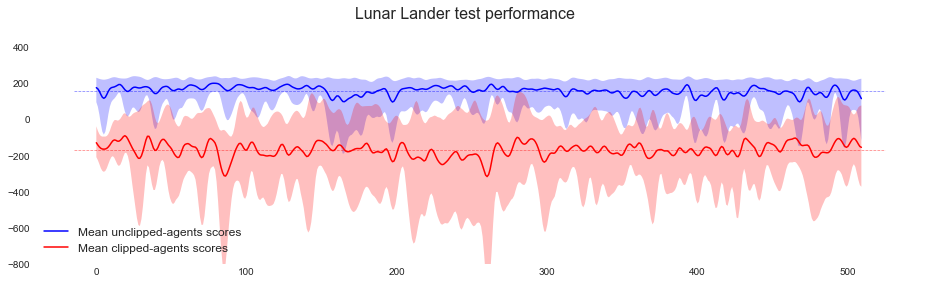

In [214]:
def compute_upper_lower_mean(reward_data, smoothing_window=20):
    smoothing_window = 20
    rewards = [np.array(data) for data in reward_data]
    ceil = np.max(rewards, axis=0)
    floor = np.min(rewards, axis=0)
    mean = sum(rewards)/len(rewards)
    return smooth(floor), smooth(ceil), smooth(mean)

    
fig, axis = plt.subplots(1, 1, figsize=(16, 4))
fig.suptitle('Lunar Lander test performance', fontsize=16, y=1.02)
spines_off([axis])
    
unclipped_floor, unclipped_ceil, unclipped_mean = compute_upper_lower_mean(unclipped_rewards)
axis.fill_between(range(len(unclipped_floor)), unclipped_floor, unclipped_ceil, where=unclipped_floor<unclipped_ceil, facecolor='blue', alpha=0.25)
axis.plot(unclipped_mean, alpha=1, c='b', label='Mean unclipped-agents scores')
axis.hlines(unclipped_mean.mean(), -15, len(clipped_floor) + 15, linestyles='dashed', linewidth=0.75, colors='b', alpha=0.5)

clipped_floor, clipped_ceil, clipped_mean = compute_upper_lower_mean(clipped_rewards)
axis.fill_between(range(len(clipped_floor)), clipped_floor, clipped_ceil, where=clipped_floor<clipped_ceil, facecolor='red', alpha=0.25)
axis.plot(clipped_mean, alpha=1, c='r', label='Mean clipped-agents scores')
axis.hlines(clipped_mean.mean(), -15, len(clipped_floor) + 15, linestyles='dashed', linewidth=0.75, colors='r', alpha=0.5)

axis.set_ylim(-800, 400);    
axis.legend(loc=3, fontsize='large');

**Above: ** Smoothed average test curves for ten agents, each trained for 3000 episodes in the LunarLander-v2 environment, and then evaluated for 500 episodes. Five were trained with reward & gradient clipping, five without. All were evaluated in the unclipped environment, following the original DQN paper description: "While we evaluated our agents on unmodified games, we made one change to the reward structure of the games during training only...  we clipped all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged."
    
<p>The shaded regions shows upper and lower limits of performance across the five test runs.</p>


This experiment seems to validate my 70% prior that training with reward clipping may sometimes be quite harmful.


# Upcoming
I'm currently writing up my experience implementing the [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) and [Distributional DQN](https://arxiv.org/abs/1707.06887) papers.